In [1]:
import pandas as pd
import sys
from pathlib import Path
import pastas as ps

# Add the 'scripts' directory to sys.path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))


### Loading Input Files

In [2]:
from knmi_pull import fetch_knmi_prec_evap
data = fetch_knmi_prec_evap("249", "2000-01-01", "2025-06-01")

In [3]:
prec = data[0]
evap = data[1]

In [4]:
# 1. Load Excel file
file_path_excel = Path("../input_files/input_single/Fugro_HB29-PB1.xlsx")
df_head = pd.read_excel(file_path_excel)

print(df_head.head())

                 Time  HB29-PB1
0 2023-11-09 11:00:00       NaN
1 2023-11-09 12:00:00       NaN
2 2023-11-09 13:00:00       NaN
3 2023-11-09 14:00:00       NaN
4 2023-11-09 15:00:00       NaN


In [5]:
# 2. Convert 'time' column to datetime using flexible parsing
df_head['time'] = pd.to_datetime(df_head['Time'], format='mixed', dayfirst=True)

# 3. Set datetime column as index
df_head.set_index('time', inplace=True)

# 4. Resample to daily mean
head_daily_mean = df_head['HB29-PB1'].resample("D").mean().dropna()

#### Waterhoogte systeem

In [6]:
# 1. Load Excel file
file_path_waterhoogte = Path("../input_files/input_single/waterhoogte_drieban.xlsx")
df = pd.read_excel(file_path_waterhoogte)

# 2. Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. Set datetime as index
df.set_index('datetime', inplace=True)

# 4. Resample to daily mean (will have missing dates if no data on some days)
waterhoogte_daily_mean = df['waterhoogte'].resample("D").mean()

# 5. Fill missing days with a method or value, e.g., forward fill or zero (if appropriate)
waterhoogte_daily_mean = waterhoogte_daily_mean.ffill()  # or .bfill(), or .fillna(0)

# 6. Now frequency can be inferred correctly
waterhoogte_daily_mean.index.freq = "D"

### Gegevenscontrole

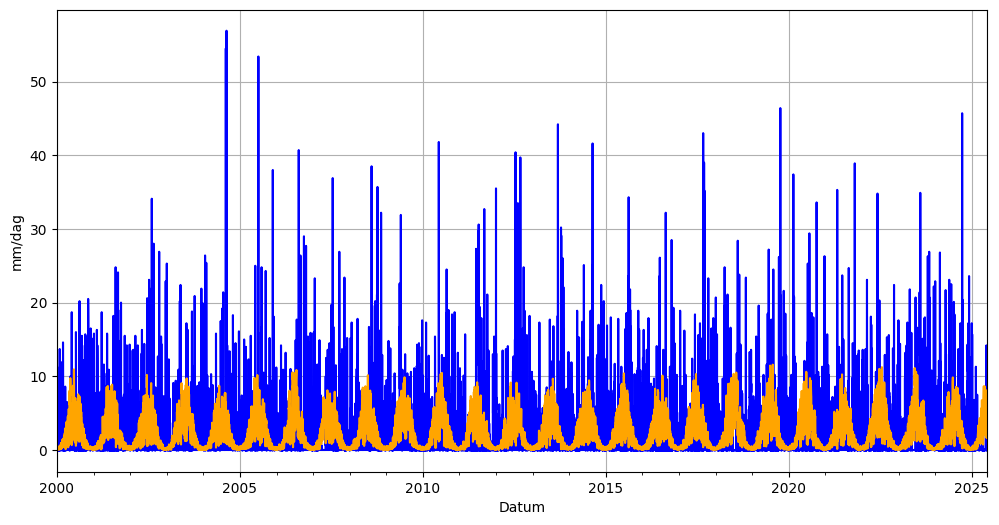

In [7]:
import matplotlib.pyplot as plt

ax1 = prec.plot(label='Precipitation', color='blue', figsize=(12, 6))
ax2 = evap.plot(label='Evaporation', color='orange')
plt.xlabel("Datum")
plt.ylabel("mm/dag")  # or your preferred unit
plt.grid(True)
plt.show()

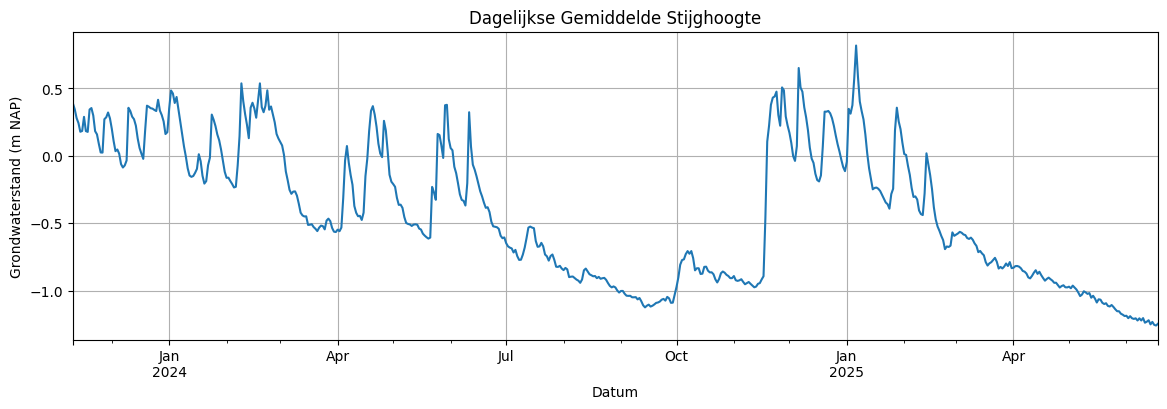

In [8]:
head_daily_mean.plot(figsize=(14, 4), title="Dagelijkse Gemiddelde Stijghoogte")
plt.xlabel("Datum")
plt.ylabel("Grondwaterstand (m NAP)")  # or your preferred unit
plt.grid(True)
plt.show()


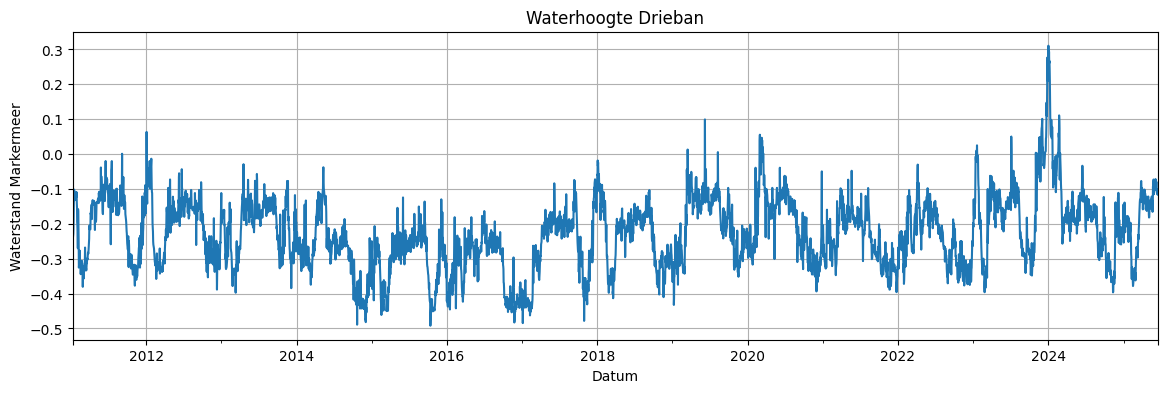

In [9]:
waterhoogte_daily_mean.plot(figsize=(14, 4), title="Waterhoogte Drieban")
plt.xlabel("Datum")
plt.ylabel("Waterstand Markermeer")  # or your preferred unit
plt.grid(True)
plt.show()


In [10]:
start_head_series = head_daily_mean.index.min()
end_head_series = head_daily_mean.index.max()

print(start_head_series, end_head_series)

2023-11-10 00:00:00 2025-06-18 00:00:00


In [11]:
import plotly.graph_objects as go

# Align all series to the index of head_daily_mean
common_index = head_daily_mean.dropna().index
prec_aligned = prec.reindex(common_index).fillna(0)
evap_aligned = evap.reindex(common_index).fillna(0)
waterhoogte_aligned = waterhoogte_daily_mean.reindex(common_index).fillna(method="ffill")

fig = go.Figure()

# Precipitation
fig.add_trace(go.Scatter(
    x=common_index, y=prec_aligned,
    mode='lines', name='Precipitation (mm/dag)',
    yaxis='y2', line=dict(color='blue')
))

# Evaporation
fig.add_trace(go.Scatter(
    x=common_index, y=evap_aligned,
    mode='lines', name='Evaporation (mm/dag)',
    yaxis='y2', line=dict(color='orange')
))

# Groundwater head
fig.add_trace(go.Scatter(
    x=common_index, y=head_daily_mean.reindex(common_index),
    mode='lines', name='Stijghoogte (m NAP)',
    yaxis='y1', line=dict(color='green')
))

# Surface water level
fig.add_trace(go.Scatter(
    x=common_index, y=waterhoogte_aligned,
    mode='lines', name='Waterhoogte Markermeer',
    yaxis='y1', line=dict(color='purple')
))

# Layout
fig.update_layout(
    title="Meteorologische en Hydrologische Tijdreeksen",
    xaxis=dict(title='Datum'),
    yaxis=dict(title='Grondwater- en Waterstand (m NAP)', side='left'),
    yaxis2=dict(title='Neerslag en Verdamping (mm/dag)', overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99),
    height=500,
    width=1000
)

fig.show()


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

### Model neerzetten

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably dive

Fit report NonlinearRechargeModel Fit Statistics
nfev    42                     EVP         78.70
nobs    587                    R2           0.79
noise   True                   RMSE         0.23
tmin    2023-11-10 00:00:00    AICc     -2845.19
tmax    2025-06-18 00:00:00    BIC      -2797.52
freq    D                      Obj          2.22
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (11 optimized)
                optimal    initial  vary
rch_A          0.677256   0.174630  True
rch_alpha      0.899380   0.100000  True
rch_a1        38.248150  10.000000  True
rch_a2       110.037952  10.000000  True
rch_f         -0.250055  -1.000000  True
extra_A        8.325379   9.805271  True
extra_n       -1.877079   1.000000  True
extra_a      342.544682  10.000000  True
extra_b        6.897707  10.000000  True
constant_d    -0.304154  -0.415548  True
noise_alpha   13.450334   1.000000  True

Warnings! (4)
Response tmax for 'rch' >

[<Axes: xlabel='time', ylabel='Head'>,
 <Axes: xlabel='time'>,
 <Axes: title={'right': "Stresses: ['Precipitation', 'ET']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'right': "Stresses: ['waterhoogte']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=11)'}>]

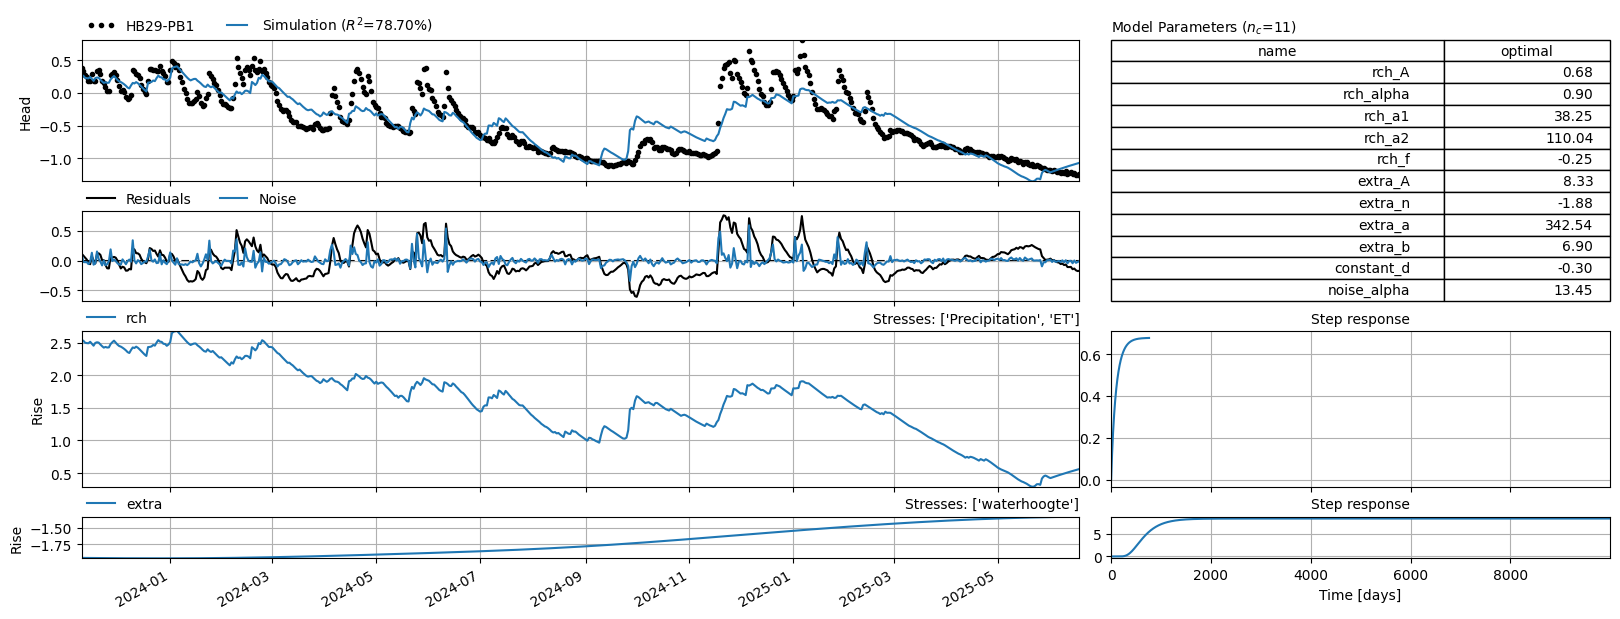

In [12]:
# 1. Create the model
ml = ps.Model(head_daily_mean, name="NonlinearRechargeModel")

# 2. Define recharge model
rch = ps.rch.Linear()  # Nonlinear recharge function
rm = ps.RechargeModel(
    prec=prec,
    evap=evap,
    recharge=rch,
    rfunc=ps.DoubleExponential(),  # Response function
    name="rch"
)
ml.add_stressmodel(rm)

# # # Optional: add extra stressor if needed
extra = ps.StressModel(waterhoogte_daily_mean, rfunc=ps.FourParam(), name="extra", settings="prec", up=True)
ml.add_stressmodel(extra)


#3. Add noise model explicitly (e.g., AR(1))
noise_model = ps.ArNoiseModel(2)  # You can specify order with ps.ArNoiseModel(order=2), etc.
ml.add_noisemodel(noise_model)

# 4. Solve the model
ml.solve(tmin=start_head_series, tmax=end_head_series, solver=ps.LeastSquares(), report=True)

# 5. Plot results
ml.plots.results(figsize=(16, 6))

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



[<Axes: xlabel='Simulated values', ylabel='Residuals'>,
 <Axes: xlabel='Simulated values', ylabel='$\\sqrt{|Residuals|}$'>,
 <Axes: title={'center': 'Noise (n=586, $\\mu$=-0.00)'}, xlabel='time', ylabel='Noise'>,
 <Axes: title={'center': 'Histogram'}, ylabel='Probability density'>,
 <Axes: xlabel='Lag [Days]', ylabel='Autocorrelation [-]'>,
 <Axes: title={'center': 'Probability Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>]

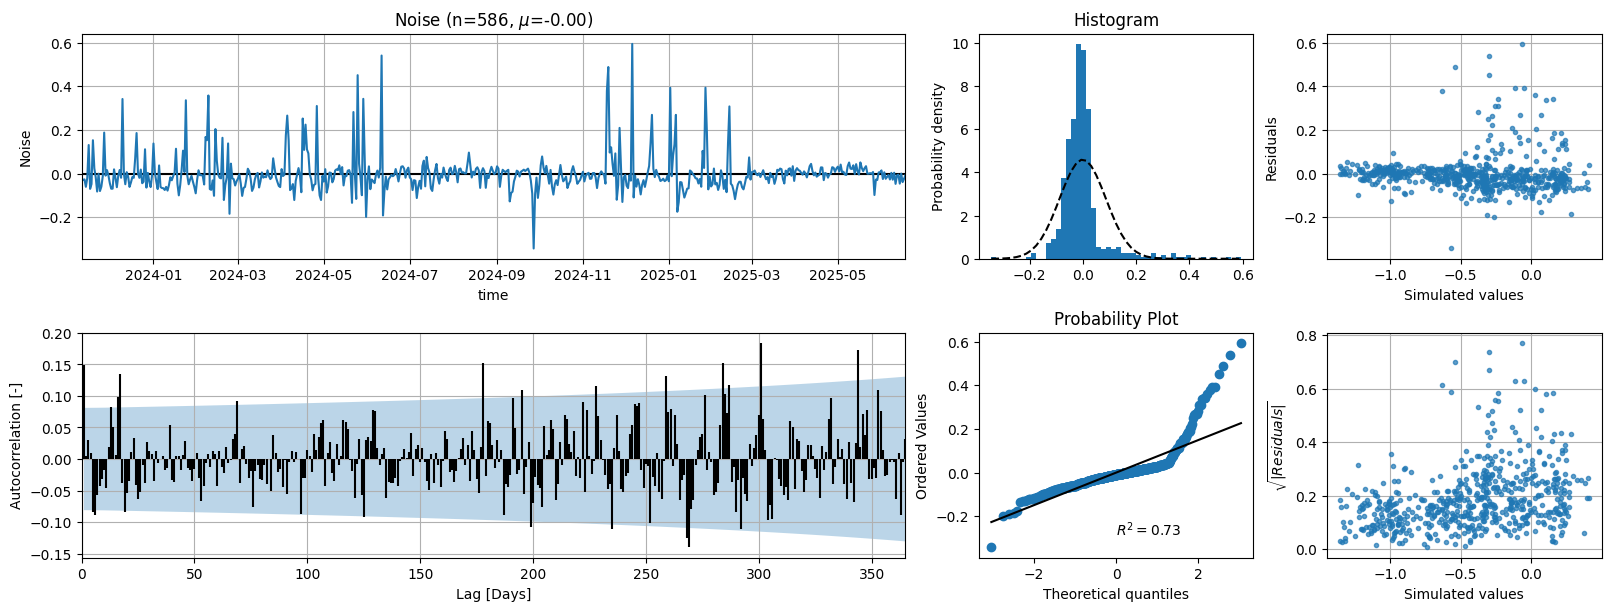

In [13]:
ml.plots.diagnostics(figsize=(16, 6))

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



array([<Axes: xlabel='time', ylabel='Head'>,
       <Axes: title={'center': 'rch (Precipitation)'}, ylabel='Rise'>,
       <Axes: title={'center': 'rch (ET)'}, ylabel='Rise'>,
       <Axes: title={'center': 'extra'}, ylabel='Rise'>], dtype=object)

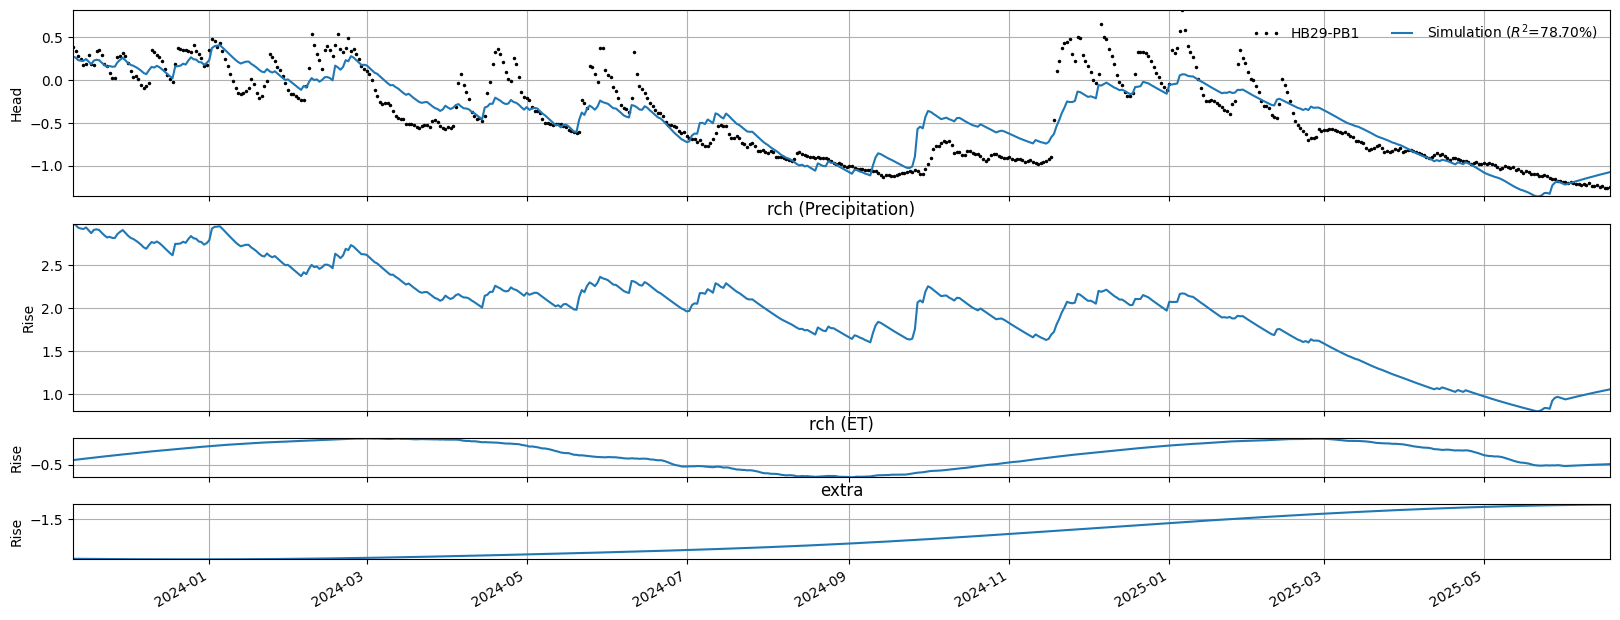

In [14]:
ml.plots.decomposition(figsize=(16, 6))

In [15]:
print(ml.stats.diagnostics(alpha=0.05))

                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.74    0.00                       True
D'Agostino     Normality    379.27    0.00                       True
Runs test      Autocorr.     -6.90    0.00                       True
Ljung-Box      Autocorr.     32.73    0.00                       True
Durbin-Watson  Autocorr.      1.70     nan                      False


c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



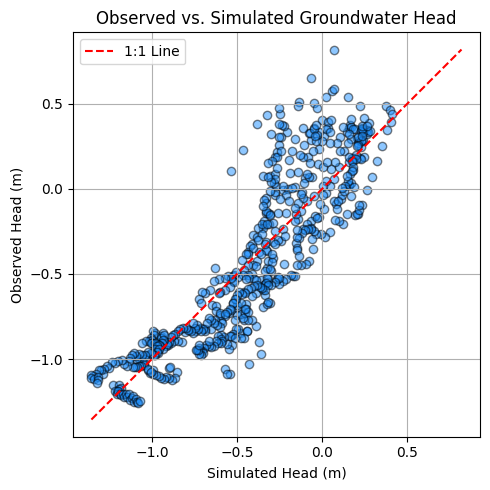

In [16]:
import matplotlib.pyplot as plt

# Get observed and simulated values
observed = ml.observations()  # <- no .series here!
simulated = ml.simulate()

# Create scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(simulated, observed, alpha=0.5, color='dodgerblue', edgecolor='k')

# Add 45-degree reference line
min_val = min(observed.min(), simulated.min())
max_val = max(observed.max(), simulated.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1:1 Line")

# Labels and title
plt.xlabel("Simulated Head (m)")
plt.ylabel("Observed Head (m)")
plt.title("Observed vs. Simulated Groundwater Head")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()


c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jeroe\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-gYPXqKkJ-py3.13\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



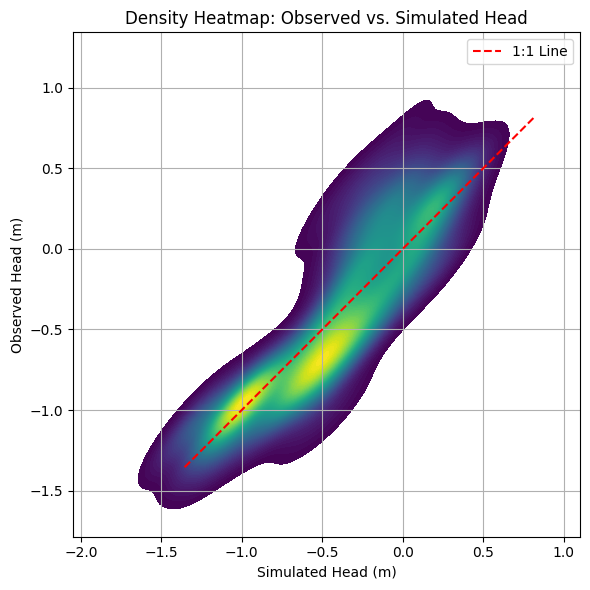

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get observed and simulated values
observed = ml.observations()
simulated = ml.simulate()

# Create density plot
plt.figure(figsize=(6, 6))
sns.kdeplot(
    x=simulated, y=observed,
    cmap="viridis", fill=True, thresh=0.01, levels=100
)

# Add 45-degree reference line
min_val = min(observed.min(), simulated.min())
max_val = max(observed.max(), simulated.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1:1 Line")

# Labels and title
plt.xlabel("Simulated Head (m)")
plt.ylabel("Observed Head (m)")
plt.title("Density Heatmap: Observed vs. Simulated Head")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()

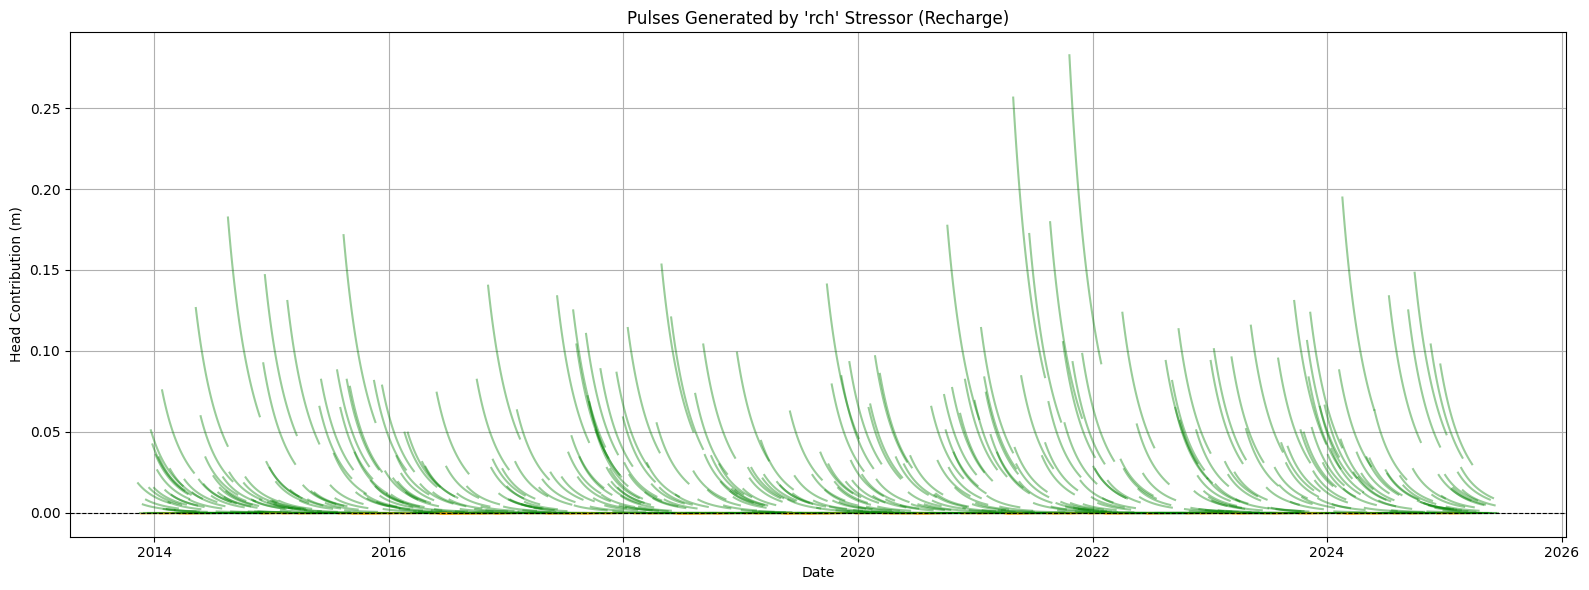

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the recharge input series (already includes prec, evap, and recharge logic)
recharge_input = ml.stressmodels['rch'].stress[0].series.asfreq("D").fillna(0)

# 2. Get parameters from the model
all_params_df = ml.parameters  # this is a DataFrame in all versions
rch_param_names = [p for p in all_params_df.index if p.startswith("rch_")]
rch_param_values = all_params_df.loc[rch_param_names, "optimal"].values

# 3. Get the response function object
rch_rfunc = ml.stressmodels['rch'].rfunc

# 4. Compute the IRF and truncate
full_irf_rch = rch_rfunc.block(rch_param_values, dt=1.0)
cutoff = 100
irf_rch = full_irf_rch[:cutoff]

# 5. Prepare plotting loop
dates = recharge_input.index
n = len(recharge_input)

plt.figure(figsize=(16, 6))

for i in range(0, n - cutoff, 5):  # step=5 to reduce clutter
    t0 = dates[i]
    t_range = pd.date_range(t0, periods=cutoff, freq="D")
    pulse = recharge_input.iloc[i] * irf_rch
    plt.plot(t_range, pulse, color='green' if pulse[0] >= 0 else 'orange', alpha=0.4)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Pulses Generated by 'rch' Stressor (Recharge)")
plt.xlabel("Date")
plt.ylabel("Head Contribution (m)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # 1. Get stress input
# stress_input = ml.stressmodels['extra'].stress[0].series.asfreq("D").fillna(0)

# # 2. Get impulse response function (IRF), truncate
# full_irf = ps.FourParam().block([A, a, b, c], dt=1.0)
# cutoff = 100
# irf = full_irf[:cutoff]

# # 3. Prepare time values
# dates = stress_input.index
# n = len(stress_input)

# # 4. Plot
# plt.figure(figsize=(16, 6))

# for i in range(0, n - cutoff, 5):  # step=5 to avoid overplotting (adjust as needed)
#     t0 = dates[i]
#     t_range = pd.date_range(t0, periods=cutoff, freq="D")
#     pulse = stress_input.iloc[i] * irf
#     plt.plot(t_range, pulse, color='blue' if pulse[0] >= 0 else 'red', alpha=0.5)

# plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
# plt.title("Pulses Generated by 'extra' Stressor (Colored by Sign)")
# plt.xlabel("Date")
# plt.ylabel("Head Contribution (m)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

NameError: name 'A' is not defined

Fit report DirectConvolutionModel   Fit Statistics
nfev    119                    EVP           78.23
nobs    587                    R2             0.78
noise   True                   RMSE           0.24
tmin    2023-11-10 00:00:00    AICc       -2839.70
tmax    2025-06-18 00:00:00    BIC        -2796.33
freq    D                      Obj            2.25
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (10 optimized)
                          optimal    initial  vary
recharge_direct_A        0.243466   0.174630  True
recharge_direct_alpha    0.812482   0.100000  True
recharge_direct_a1      14.211830  10.000000  True
recharge_direct_a2      68.618551  10.000000  True
extra_A                  0.035467   9.805271  True
extra_n                 -9.999958   1.000000  True
extra_a                101.316151  10.000000  True
extra_b                 19.016807  10.000000  True
constant_d              -0.383751  -0.415548  True
nois

[<Axes: xlabel='time', ylabel='Head'>,
 <Axes: xlabel='time'>,
 <Axes: title={'right': "Stresses: ['None']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'right': "Stresses: ['waterhoogte']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=10)'}>]

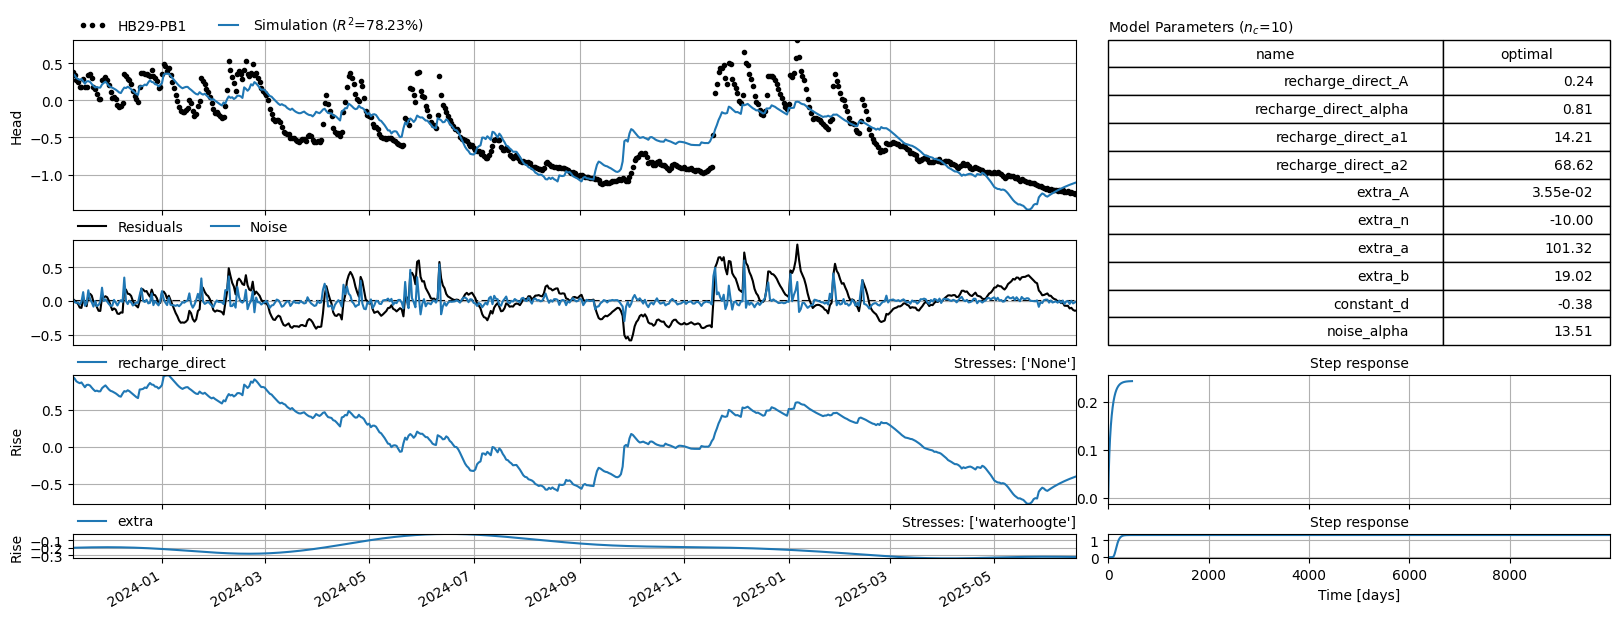

In [28]:
import pastas as ps

# 1. Create the model
ml2 = ps.Model(head_daily_mean, name="DirectConvolutionModel")

# 2. Compute your recharge series
recharge = prec - evap

# 3. Add a StressModel *with* settings="prec"
sm = ps.StressModel(
    stress=recharge,
    rfunc=ps.DoubleExponential(),   # your response function
    name="recharge_direct",
    settings="prec"                 # <— tell Pastas to fill zeros outside range
)
ml2.add_stressmodel(sm)

# 4. (Optional) add your extra stressor with its own settings if needed
extra = ps.StressModel(
    stress=waterhoogte_daily_mean,
    rfunc=ps.FourParam(),
    name="extra",
    settings="prec",  # or whatever is appropriate for that series
    up=True
)
ml2.add_stressmodel(extra)

# 5. Add your noise model
noise_model = ps.ArNoiseModel()  # You can specify order with ps.ArNoiseModel(order=2), etc.
ml2.add_noisemodel(noise_model)

# 6. Solve
ml2.solve(
    tmin=start_head_series,
    tmax=end_head_series,
    solver=ps.LeastSquares(),
    report=True
)

# 7. Plot results
ml2.plots.results(figsize=(16, 6))

Fit report SeparateStressModel    Fit Statistics
nfev    339                    EVP         73.69
nobs    587                    R2           0.74
noise   False                  RMSE         0.26
tmin    2023-11-10 00:00:00    AICc     -1562.52
tmax    2025-06-18 00:00:00    BIC      -1532.09
freq    D                      Obj         20.00
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (7 optimized)
                    optimal    initial  vary
precipitation_A    1.511508   0.210716  True
precipitation_n    0.989738   1.000000  True
precipitation_a  144.027179  10.000000  True
evaporation_A     43.287119   0.433329  True
evaporation_n     78.873439   1.000000  True
evaporation_a     67.483776  10.000000  True
constant_d        -5.551619  -0.415548  True

Warnings! (4)
Response tmax for 'precipitation' > than calibration period.
Response tmax for 'evaporation' > than calibration period.
Response tmax for 'precipitation' > th

[<Axes: xlabel='time', ylabel='Head'>,
 <Axes: xlabel='time'>,
 <Axes: title={'right': "Stresses: ['Precipitation']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'right': "Stresses: ['ET']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=7)'}>]

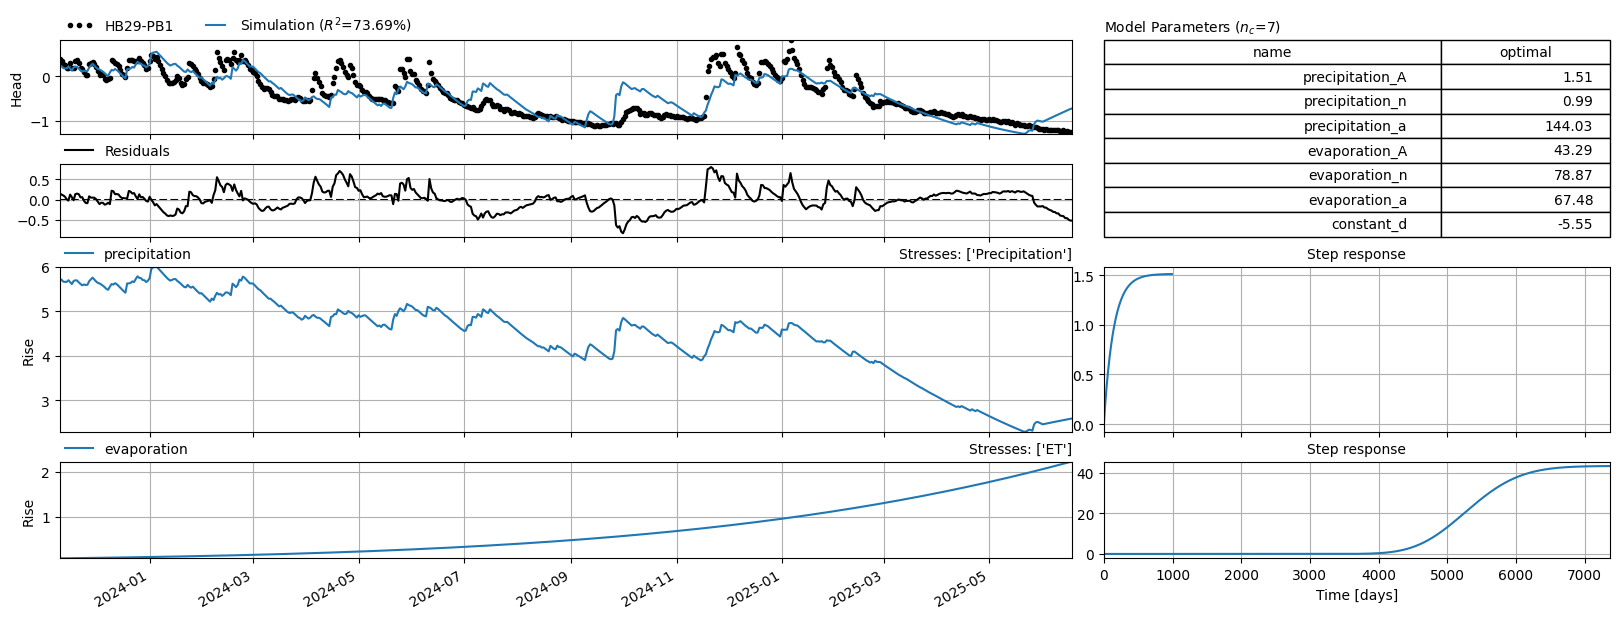

In [42]:
import pastas as ps

# 1. Create the model
ml3 = ps.Model(head_daily_mean, name="SeparateStressModel")

# 2. Add precipitation as its own StressModel
sm_prec = ps.StressModel(
    stress=prec,
    rfunc=ps.Gamma(),      # e.g. Gamma impulse response for precipitation
    name="precipitation",
    settings="prec"        # fill zeros outside data range
)
ml3.add_stressmodel(sm_prec)

# 3. Add evaporation as its own StressModel
sm_evap = ps.StressModel(
    stress=evap,
    rfunc=ps.Gamma(),  # e.g. Exponential impulse response for evaporation
    name="evaporation",
    settings="evap"          # fill zeros & treat it as a negative flux
)
ml3.add_stressmodel(sm_evap)

# 4. (Optional) add the same extra stressor you used before
# extra = ps.StressModel(
#     stress=waterhoogte_daily_mean,
#     rfunc=ps.FourParam(),
#     name="extra",
#     settings="prec",
#     up=True
# )
# ml3.add_stressmodel(extra)

# 5. Add your noise model
#noise_model = ps.ArNoiseModel()  # You can specify order with ps.ArNoiseModel(order=2), etc.
#ml3.add_noisemodel(noise_model)

# 6. Solve
ml3.solve(
    tmin=start_head_series,
    tmax=end_head_series,
    solver=ps.LeastSquares(),
    report=True
)

# 7. Plot results
ml3.plots.results(figsize=(16, 6))
